In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt
import math
import copy
from concurrent.futures import ThreadPoolExecutor
from concurrent.futures import ProcessPoolExecutor
from tensorflow.keras.layers import Input
from sklearn.preprocessing import StandardScaler
from keras.layers import Dropout

In [2]:
# HIPERPARÂMETROS:
start_date = '2014-08-21'
W = 300  # Lembrando que o tamanho do treinamento será W - w
w = 7

In [3]:
# Criptomoedas que vamos escolher para nosso portifólio
cryptos = [
    'BTC-USD', 'ETH-USD', 'LTC-USD'
]

In [4]:
## Função para calcular o retorno logarítmico
def log_return(series):
    return np.log(series['Close'] / series['Open'])

In [5]:
def fracdiff_weights(d, size):
    we = [1.0]
    for k in range(1, size):
        we.append(-we[-1] * ((d - k + 1)) / k)
    return np.array(we[::-1])

In [6]:
data = {}
for crypto in cryptos:
    # Baixar dados e calcular retorno logarítmico
    df = yf.download(crypto, start=start_date, end=pd.to_datetime("today").strftime("%Y-%m-%d"), interval='1d')
    df['Return'] = log_return(df)

    # Construir DataFrame final, pegando o retorno do dia anterior e o atual
    df_final = pd.DataFrame({
        'Crypto_Price': np.log(df['Open'].squeeze()),
        'Crypto_Return_Today': df['Return']
    }).dropna()


    data[crypto] = df_final

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [7]:
data[crypto]

,Crypto_Price,Crypto_Return_Today
Date,,
2014-09-17,1.626470,-0.005390
2014-09-18,1.622439,-0.078024
2014-09-19,1.544855,-0.079802
2014-09-20,1.465383,-0.009926
2014-09-21,1.449990,-0.004031
...,...,...
2024-11-11,4.337593,0.045925
2024-11-12,4.383518,-0.040611
2024-11-13,4.342874,-0.019436


In [8]:
aux = yf.download('BTC-USD', start=start_date, end=pd.to_datetime("today").strftime("%Y-%m-%d"), interval='1d')
aux['Return'] = np.log(aux['Open'])
aux = pd.DataFrame({'Aux_Price': aux['Return']})

for crypto in cryptos:
    if crypto != 'BTC-USD':
        data[crypto] = pd.merge(aux, data[crypto],  left_index=True, right_index=True, how='outer').dropna()

[*********************100%%**********************]  1 of 1 completed


In [9]:
data['ETH-USD']

,Aux_Price,Crypto_Price,Crypto_Return_Today
Date,,,
2017-11-09,8.915544,5.732192,0.038888
2017-11-10,8.878181,5.770416,-0.069126
2017-11-11,8.797641,5.699058,0.052501
2017-11-12,8.747582,5.751588,-0.021787
2017-11-13,8.689170,5.726929,0.031076
...,...,...,...
2024-11-11,11.295657,8.068295,0.055800
2024-11-12,11.393078,8.124196,-0.038938
2024-11-13,11.384296,8.084730,-0.016140


In [10]:
aux = yf.download('ETH-USD', start=start_date, end=pd.to_datetime("today").strftime("%Y-%m-%d"), interval='1d')
aux['Return'] = aux['Open']
aux = pd.DataFrame({'Aux_Price': aux['Return']})

data['BTC-USD'] = pd.merge(aux, data['BTC-USD'],  left_index=True, right_index=True, how='outer').dropna()


[*********************100%%**********************]  1 of 1 completed


In [11]:
from statsmodels.tsa.stattools import adfuller

window_size = 10  # Ajuste para o tamanho desejado do histórico
def fracdiff(series, weights):
    diff_series = []
    for i in range(window_size, len(series)):
        window = series[i - window_size:i]
        diff_value = np.dot(weights, window)
        diff_series.append(diff_value)
    return pd.Series(diff_series, index=series.index[window_size:])

def find_optimal_d(series, window_size=10, threshold=0.0001, d_step=0.01, max_d=1.0):
    d = 0.4  # Inicie com d = 0.2
    while d <= max_d:
        # Calcula os pesos e a série diferenciada fracionariamente
        weights = fracdiff_weights(d, window_size)
        diff_series = fracdiff(series, weights).dropna()

        # Executa o teste ADF
        adf_result = adfuller(diff_series)
        p_value = adf_result[1]

        # Verifica se o p_value é menor que o threshold
        if p_value < threshold:
            return d, p_value  # Retorna o d encontrado e o p_value correspondente

        # Aumenta d pelo passo definido
        d += d_step

    # Caso não encontre um d adequado
    return 1, None

In [12]:
data[crypto]

,Aux_Price,Crypto_Price,Crypto_Return_Today
Date,,,
2014-09-17,6.143894,1.626470,-0.005390
2014-09-18,6.124377,1.622439,-0.078024
2014-09-19,6.049976,1.544855,-0.079802
2014-09-20,5.978058,1.465383,-0.009926
2014-09-21,6.011475,1.449990,-0.004031
...,...,...,...
2024-11-11,11.295657,4.337593,0.045925
2024-11-12,11.393078,4.383518,-0.040611
2024-11-13,11.384296,4.342874,-0.019436


In [13]:
data_complete = {}
for crypto in cryptos:
    # Baixar dados e calcular retorno logarítmico
    df = yf.download(crypto, start=start_date, end=pd.to_datetime("today").strftime("%Y-%m-%d"), interval='1d')
    df['Return'] = log_return(df)

    # Construir DataFrame final, pegando o retorno do dia anterior e o atual
    df_final = pd.DataFrame({
        'Crypto_Return_Today': df['Return']
    }).dropna()

    # Adicionar a coluna 'exp_value' com valores NaN
    df_final['exp_value'] = np.nan

    # Armazenar no dicionário
    data_complete[crypto] = df_final

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [14]:
print(len(data_complete['ETH-USD']))
data_complete['ETH-USD']

2564


,Crypto_Return_Today,exp_value
Date,,
2017-11-09,0.038888,NaN
2017-11-10,-0.069126,NaN
2017-11-11,0.052501,NaN
2017-11-12,-0.021787,NaN
2017-11-13,0.031076,NaN
...,...,...
2024-11-11,0.055800,NaN
2024-11-12,-0.038938,NaN
2024-11-13,-0.016140,NaN


In [15]:
# Criando a função First Transformation, que recebe uma tabela contendo os retornos de todos os dias dos ultimos X anos e retorno um vetor, que cada elemento
# é uma tabela do retorno de W+1 dias.
def FirstTransform(df, W):
    vet = []
    Linhas, Colunas = df.shape
    for i in range(Linhas, W+1, -1):
        vet.append(df.iloc[(i-W-1):i])
    return vet

In [16]:
# Aqui eu perco W+1 dias do meu dataset
for crypto in cryptos:
    data[crypto] = FirstTransform(data[crypto], W)

In [17]:
print(len(data['ETH-USD']))
data['ETH-USD'][0]

2263


,Aux_Price,Crypto_Price,Crypto_Return_Today
Date,,,
2024-01-20,10.636446,7.819977,-0.008170
2024-01-21,10.637572,7.811892,-0.006453
2024-01-22,10.634741,7.805877,-0.060516
2024-01-23,10.584530,7.745415,-0.030877
2024-01-24,10.593570,7.715012,-0.003659
...,...,...,...
2024-11-11,11.295657,8.068295,0.055800
2024-11-12,11.393078,8.124196,-0.038938
2024-11-13,11.384296,8.084730,-0.016140


## 2.2 Separar em treinamento e teste - Permitir Bagging

In [18]:
optimal_d = {}
p_value = {}
for crypto in cryptos:
    optimal_d[crypto] = {}
    p_value[crypto] = {}

In [19]:
for crypto in cryptos:
  optimal_d[crypto] = pd.read_csv(f"{crypto}_optimal_d2.csv", index_col = 0)

FileNotFoundError: [Errno 2] No such file or directory: 'BTC-USD_optimal_d2.csv'

In [ ]:
for crypto in cryptos:
  optimal_d[crypto] = optimal_d[crypto].to_numpy().flatten()

In [ ]:
for crypto in cryptos:
    print(crypto, len(optimal_d[crypto]))

for crypto in cryptos:
    print(crypto, len(data[crypto]))

BTC-USD 2263
ETH-USD 2263
BTC-USD 2253
ETH-USD 2253


In [ ]:
data['BTC-USD'][0]

,Aux_Price,Crypto_Price,Crypto_Return_Today
Date,,,
2024-01-10,2344.923584,10.739035,0.010916
2024-01-11,2584.171631,10.750558,-0.006181
2024-01-12,2619.177002,10.744080,-0.078545
2024-01-13,2522.933838,10.664280,0.001003
2024-01-14,2578.003662,10.665280,-0.024718
...,...,...,...
2024-11-11,3191.656982,11.295657,0.097375
2024-11-12,3375.154785,11.393078,-0.008488
2024-11-13,3244.543213,11.384296,0.029739


In [ ]:
window_size = 10

for crypto in cryptos:
  if crypto != 'BTC-USD':
    for day in range(len(data[crypto])):
      if day < len(data['BTC-USD']):
        daily_data = data[crypto][day].copy()
        if d = 0
        d = optimal_d['BTC-USD'][day] ## LEMBRAR DE RECORRIGIR
        weights = fracdiff_weights(d, window_size)
        daily_data['diff_Aux_Price'] = fracdiff(daily_data['Aux_Price'], weights).shift(-1)

        columns = list(daily_data.columns)
        columns[-2], columns[-1] = columns[-1], columns[-2]
        data[crypto][day] = daily_data[columns]


        daily_data2 = data[crypto][day].copy()
        d = optimal_d[crypto][day]
        weights = fracdiff_weights(d, window_size)
        daily_data2['diff_Crypto_Price'] = fracdiff(daily_data2['Crypto_Price'], weights).shift(-1)

        columns = list(daily_data2.columns)
        columns[-2], columns[-1] = columns[-1], columns[-2]
        data[crypto][day] = daily_data2[columns]
  if crypto == 'BTC-USD':
      for day in range(len(data[crypto])):
        daily_data = data[crypto][day].copy()
        d = optimal_d['ETH-USD'][day]
        weights = fracdiff_weights(d, window_size)
        daily_data['diff_Aux_Price'] = fracdiff(daily_data['Aux_Price'], weights).shift(-1)

        columns = list(daily_data.columns)
        columns[-2], columns[-1] = columns[-1], columns[-2]
        data[crypto][day] = daily_data[columns]


        daily_data2 = data[crypto][day].copy()
        d = optimal_d[crypto][day]
        weights = fracdiff_weights(d, window_size)
        daily_data2['diff_Crypto_Price'] = fracdiff(daily_data2['Crypto_Price'], weights).shift(-1)

        columns = list(daily_data2.columns)
        columns[-2], columns[-1] = columns[-1], columns[-2]
        data[crypto][day] = daily_data2[columns]

ADF t-statistic para série fracionariamente diferenciada: -4.592081968292025
ADF p-value para série fracionariamente diferenciada: 0.00013358062539423597
d_value: 0.7000000000000003


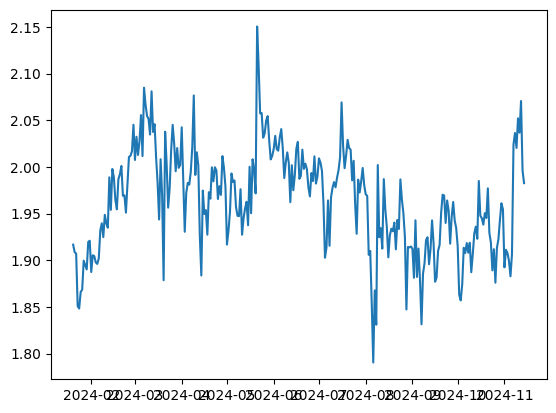

In [210]:
#adf_result = adfuller(close_prices_frac_diff.dropna().loc['2019-06-30':])  # Remova valores NA, se houver
adf_result = adfuller(data[crypto][0]['diff_Crypto_Price'].dropna())
# Obtenha o t-statistic e o p-value
t_statistic = adf_result[0]
p_value = adf_result[1]


print("ADF t-statistic para série fracionariamente diferenciada:", t_statistic)
print("ADF p-value para série fracionariamente diferenciada:", p_value)
print("d_value:", optimal_d[crypto][1500])

#plt.plot(pd.DataFrame(close_prices_frac_diff.loc['2019-06-30':]))
plt.plot(pd.DataFrame(data[crypto][0]['diff_Crypto_Price']))

In [211]:
data['BTC-USD'][0].dropna()

,Aux_Price,Crypto_Price,diff_Aux_Price,diff_Crypto_Price,Crypto_Return_Today
Date,,,,,
2024-01-20,2489.847656,10.636446,603.395841,2.504886,0.000984
2024-01-21,2469.798584,10.637572,583.422576,2.507869,-0.003021
2024-01-22,2454.987305,10.634741,580.043666,2.506697,-0.050498
2024-01-23,2310.951660,10.584530,446.136758,2.458469,0.008236
2024-01-24,2241.749756,10.593570,443.548200,2.490550,0.004990
...,...,...,...,...,...
2024-11-10,3130.729248,11.248641,989.586076,2.674508,0.047050
2024-11-11,3191.656982,11.295657,948.190046,2.715383,0.097375
2024-11-12,3375.154785,11.393078,1065.912633,2.788430,-0.008488


In [212]:
for crypto in cryptos:
  for day in range(len(data[crypto])):
    data[crypto][day] = data[crypto][day].dropna()
    data[crypto][day] = data[crypto][day].drop(columns = ['Aux_Price', 'Crypto_Price'])

In [224]:
data['BTC-USD'][0]

,diff_Aux_Price,diff_Crypto_Price,Crypto_Return_Today
Date,,,
2024-01-20,603.395841,2.504886,0.000984
2024-01-21,583.422576,2.507869,-0.003021
2024-01-22,580.043666,2.506697,-0.050498
2024-01-23,446.136758,2.458469,0.008236
2024-01-24,443.548200,2.490550,0.004990
...,...,...,...
2024-11-09,887.261807,2.681190,0.002904
2024-11-10,989.586076,2.674508,0.047050
2024-11-11,948.190046,2.715383,0.097375


In [214]:
test_target = {}
for crypto in cryptos:
    row = []
    for i in range(len(data[crypto])):
        row.append((pd.DataFrame(data[crypto][i].iloc[-1])).T)
        data[crypto][i] = data[crypto][i].drop(data[crypto][i].index[-1])
    test_target[crypto] = row

In [215]:
data['ETH-USD'][0], test_target['ETH-USD'][0]['Crypto_Return_Today']

(            diff_Aux_Price  diff_Crypto_Price  Crypto_Return_Today
 Date                                                              
 2024-01-20        2.504886           1.916673            -0.008170
 2024-01-21        2.507869           1.908568            -0.006453
 2024-01-22        2.506697           1.907126            -0.060516
 2024-01-23        2.458469           1.850754            -0.030877
 2024-01-24        2.490550           1.848227            -0.003659
 ...                    ...                ...                  ...
 2024-11-09        2.681190           2.020271             0.055267
 2024-11-10        2.674508           2.051975             0.019172
 2024-11-11        2.715383           2.036607             0.055800
 2024-11-12        2.788430           2.070532            -0.038938
 2024-11-13        2.728328           1.996101            -0.016140
 
 [299 rows x 3 columns],
 2024-11-14   -0.042739
 Name: Crypto_Return_Today, dtype: float64)

## 2.3 Bagging

In [216]:
# Definindo uma função bagging, que recebe um dataframe e retorna um vetor de dataframes.
def Bagging(df, n, gamma):
    df_bagged = []
    for i in range(gamma):
        aux = df.sample(n = n, random_state = i)
        aux = aux.sort_index()
        df_bagged.append(aux)
    return df_bagged

# 3. Machine Learning

* vamos peimeiro fazer do modo 1 para todos os dias
* depois aplicar para os ultimos 290 dias o modo 2 (contém bagging e purge K-Fold-CV)

## 3.1 Função do Modelo


In [217]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau


def create_model(a, b):
    model = Sequential([
        Input(shape=(a, b)),
        Conv1D(15, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        LSTM(units=50, return_sequences=False),
        BatchNormalization(),
        Dropout(0.5),
        Dense(units=128, activation='relu'),
        BatchNormalization(),
        Dropout(0.2),
        Dense(units=1)
    ])
    optimizer = RMSprop(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


In [218]:
# Função do modelo LSTM
def Model(df, time_step, features, model=None):
    # Normalizando o dataframe
    #scaler = StandardScaler()
    #df_scaled = scaler.fit_transform(df)
    #df_array = np.array(df_scaled)
    df_array = np.array(df)

    # Transformando no formato LSTM
    X_lstm = []
    y_lstm = []
    for i in range(time_step, len(df_array)):
        X_lstm.append(df_array[i-time_step:i+1, :-1])  # Pega 'timesteps' linhas anteriores
        y_lstm.append(df_array[i, -1])  # Alvo é o valor do dia seguinte
    X_lstm = np.array(X_lstm)
    y_lstm = np.array(y_lstm)


    # Conjunto de validação - primeiros 20 elementos
    X_val = X_lstm[-20:-1]
    y_val = y_lstm[-20:-1]
    y_val = pd.DataFrame(y_val).to_numpy().reshape((len(y_val), 1))

    # Separar o X_train (todos exceto o último 20 elemento)
    X_train = X_lstm[:-20]
    y_train = y_lstm[:-20]
    y_train = pd.DataFrame(y_train).to_numpy()
    y_train = y_train.reshape((len(y_train), 1))
    y_train.shape

    # X_test e y_test
    X_test = X_lstm[-1:]
    y_test = y_lstm[-1:]
    y_test = y_lstm[-1:]
    y_test = pd.DataFrame(y_test).to_numpy()
    y_test = y_test.reshape((len(y_test), 1))

    early_stopping = EarlyStopping(monitor='val_loss', patience=40, restore_best_weights=True)
    # Arquitetura 2:
    model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs= 300, verbose=0, callbacks=[early_stopping])
    # Fazer a previsão
    y_hat_scaled = model.predict(X_test)


    return y_hat_scaled

##  3.2 Treinamento com Paralelismo e Geração dos Expected Values

In [219]:
def Add(y_hat, data_complete, ind, crypto):
    data_complete[crypto].at[ind, 'exp_value'] = y_hat

In [220]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print("Usando GPU:", physical_devices[0])
else:
    print("Usando CPU")

Usando CPU


In [221]:
for crypto in cryptos:
    print(len(data[crypto]))
len(data['ETH-USD'][0])

2253
2253


299

In [223]:
data['ETH-USD'][0]

,diff_Aux_Price,diff_Crypto_Price,Crypto_Return_Today
Date,,,
2024-01-20,2.504886,1.916673,-0.008170
2024-01-21,2.507869,1.908568,-0.006453
2024-01-22,2.506697,1.907126,-0.060516
2024-01-23,2.458469,1.850754,-0.030877
2024-01-24,2.490550,1.848227,-0.003659
...,...,...,...
2024-11-09,2.681190,2.020271,0.055267
2024-11-10,2.674508,2.051975,0.019172
2024-11-11,2.715383,2.036607,0.055800


In [179]:
test_target['ETH-USD'][1900]
test_target['ETH-USD'][2000]

,diff_Aux_Price,diff_Crypto_Price,Crypto_Return_Today
2019-05-25,120.01726,36.957892,0.008239


In [ ]:
aux = data_complete['ETH-USD'].loc['2019-02-13':'2019-09-01']
num_positive = (aux['Crypto_Return_Today'] > 0).sum()
num_negative = (aux['Crypto_Return_Today'] < 0).sum()

print("\n\n--------------------------------------------------------")
print("\n\nCriptomoeda: ", 'ETH')
print("\n                              Real")
print("\nNumero de Subidas: ",num_positive,"   |   ",100*num_positive / (num_negative + num_positive),"%")
print("\nNumero de Quedas : ",num_negative,"   |   ",100*num_negative / (num_negative + num_positive),"%")



--------------------------------------------------------


Criptomoeda:  ETH

                              Real

Numero de Subidas:  105    |    52.23880597014925 %

Numero de Quedas :  96    |    47.76119402985075 %


In [180]:
cryptos = [
    'BTC-USD', 'ETH-USD'
]
# Função que processa cada criptomoeda (paralelismo será aplicado aqui)
def process_crypto(crypto, data, test_target, data_complete, time_step, features):
    # Criar um modelo para cada criptomoeda
    for day in range(1900, 2000):
        model = create_model(time_step, features)

        df_train = data[crypto][day].copy()  # df é uma tabela de 300 linhas e uma coluna
        df_test = test_target[crypto][day].copy()  # df_test é uma tabela com 1 linha e uma coluna
        df = pd.concat([df_train, df_test], ignore_index=True)  # Unindo as duas tabelas

        scaler = StandardScaler()
        df = scaler.fit_transform(df)

        y_hat_scaled = Model(df, time_step, features, model=model)  # Chamar o modelo para previsão

        y_hat_scaled = np.repeat(y_hat_scaled, features+1, axis=1)
        y_hat_scaled = pd.DataFrame(y_hat_scaled, columns=(['Predictions_1'], ['Predictions_2'], ['Predictions_3']))

        y_hat = scaler.inverse_transform(y_hat_scaled)[0][features]

        Add(y_hat, data_complete, df_test.index[0], crypto)  # Adicionar o resultado na tabela final

    print("\nMoeda: ", crypto, " processada")

# Número de samples que vamos testar o modelo
time_step = w
features = 2

# Criar o executor para rodar as criptomoedas em paralelo
with ThreadPoolExecutor() as executor:
    # Executar o processo para cada criptomoeda simultaneamente
    futures = [
        executor.submit(process_crypto, crypto, data, test_target, data_complete, time_step, features)
        for crypto in cryptos
    ]

    # Aguardar a conclusão de todas as threads
    for future in futures:
        future.result()

print("Processamento em paralelo finalizado.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 324ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

42min para 100 dias


In [181]:
import winsound

# Frequência em Hertz e duração em milissegundos
frequencia = 2000  # 1 kHz
duracao = 3000      # 500 ms

# Emite o som
winsound.Beep(frequencia, duracao)

In [182]:
df = data_complete['BTC-USD']
df.dropna()

,Crypto_Return_Today,exp_value
Date,,
2019-05-26,0.073921,-0.001701
2019-05-27,0.015070,-0.000124
2019-05-28,-0.009450,0.008004
2019-05-29,-0.006802,0.004577
2019-05-30,-0.040319,0.006099
...,...,...
2019-08-29,-0.025598,-0.008697
2019-08-30,0.008720,-0.011368
2019-08-31,0.003445,0.004174


In [183]:
data_visual = data_complete

In [184]:
for crypto in cryptos:
    df = data_visual[crypto]
    df['ae'] = df['exp_value'] - df['Crypto_Return_Today']
    df['ae'] = abs(df['ae'])
    df = df.dropna()
    num_positive = (df['Crypto_Return_Today'] > 0).sum()
    num_negative = (df['Crypto_Return_Today'] < 0).sum()

    hat_pos = (df['exp_value'] > 0).sum()
    hat_neg = (df['exp_value'] < 0).sum()


    TP = ((df['Crypto_Return_Today'] > 0)  & (df['exp_value'] > 0)).sum()
    TN = ((df['Crypto_Return_Today'] < 0)  & (df['exp_value'] < 0)).sum()
    FP = ((df['Crypto_Return_Today'] < 0)  & (df['exp_value'] > 0)).sum()
    FN = ((df['Crypto_Return_Today'] > 0)  & (df['exp_value'] < 0)).sum()

    #rmse = np.sqrt(((df['Crypto_Return_Today'] - df['exp_value']) ** 2).mean())
    print("\n\n--------------------------------------------------------")
    print("\n\nCriptomoeda: ", crypto)
    print("\n                              Real")
    print("\nNumero de Subidas: ",num_positive,"   |   ",100*num_positive / (num_negative + num_positive),"%")
    print("\nNumero de Quedas : ",num_negative,"   |   ",100*num_negative / (num_negative + num_positive),"%")

    print("\n                              Predito")
    print("\nNumero de Subidas: ",hat_pos,"   |   ", 100*hat_pos / (hat_neg + hat_pos),"%")
    print("\nNumero de Quedas : ",hat_neg,"   |   ", 100*hat_neg / (hat_neg + hat_pos),"%")

    print("\nMean Absolute Error MAE: ", df['ae'].mean())
    #print("\nRoot Mean Squared Error RMSE: ", rmse)
    print("\nAcc: ", (TP+TN) / (TP + TN + FN + FP))
    print("\nSen: ", (TP) / (TP + FN)) # significa, entre os que subiram, quantos % eu consegui identificar que realmente subiu
    print("\nSpe: ", (TP) / (TP + FN)) # significa, entre os que cairam, quantos % eu consegui identificar que realmente caiu
    print("\nPre: ", (TP) / (TP + FP)) # significa, entre os que eu disse que ia subir, quantos % realmente subiram
    limite_90 = df['exp_value'].quantile(0.9)

    TP = ((df['Crypto_Return_Today'] > 0)  & (df['exp_value'] > 0) & (df['exp_value'] >= limite_90)).sum()
    FP = (((df['Crypto_Return_Today'] < 0)  & (df['exp_value'] > 0)) & (df['exp_value'] >= limite_90)).sum()


    menor_valor_10_maiores = df[df['exp_value'] >= limite_90]['exp_value'].min()
    print("\nLower bound dos 10% maiores: ", menor_valor_10_maiores)

    print("\nPrecisao para maiores que 0.008: ", (TP) / (TP + FP)) # significa, entre os que eu disse que ia subir, quantos % realmente subiram



--------------------------------------------------------


Criptomoeda:  BTC-USD

                              Real

Numero de Subidas:  56    |    56.0 %

Numero de Quedas :  44    |    44.0 %

                              Predito

Numero de Subidas:  61    |    61.0 %

Numero de Quedas :  39    |    39.0 %

Mean Absolute Error MAE:  0.035843430227942036

Acc:  0.47

Sen:  0.5714285714285714

Spe:  0.5714285714285714

Pre:  0.5245901639344263

Lower bound dos 10% maiores:  0.00811677984893322

Precisao para maiores que 0.008:  0.6


--------------------------------------------------------


Criptomoeda:  ETH-USD

                              Real

Numero de Subidas:  52    |    52.0 %

Numero de Quedas :  48    |    48.0 %

                              Predito

Numero de Subidas:  53    |    53.0 %

Numero de Quedas :  47    |    47.0 %

Mean Absolute Error MAE:  0.03492571854864437

Acc:  0.43

Sen:  0.46153846153846156

Spe:  0.46153846153846156

Pre:  0.4528301886792453

Lowe

In [ ]:
data_aux = {}
for crypto in cryptos:
    data_aux[crypto] = pd.read_csv(f"{crypto}.csv", index_col='Date')

In [ ]:
data_aux['BTC-USD'].dropna()

,Crypto_Return_Today,exp_value,ae
Date,,,
2019-02-13,-0.005911,-0.000663,0.005248
2019-02-14,-0.003943,-0.000381,0.003561
2019-02-15,0.000951,-0.002385,0.003336
2019-02-16,0.004008,-0.000742,0.004749
2019-02-17,0.011079,-0.000184,0.011263
...,...,...,...
2019-10-29,0.019196,0.005857,0.013339
2019-10-30,-0.023271,0.004103,0.027373
2019-10-31,-0.000312,0.005313,0.005625


In [ ]:
data_aux['BTC-USD'][-2100:]
#data_complete['BTC-USD'][:-2100]

,Crypto_Return_Today,exp_value,ae
Date,,,
2019-02-13,-0.005911,-0.000663,0.005248
2019-02-14,-0.003943,-0.000381,0.003561
2019-02-15,0.000951,-0.002385,0.003336
2019-02-16,0.004008,-0.000742,0.004749
2019-02-17,0.011079,-0.000184,0.011263
...,...,...,...
2024-11-08,0.008431,NaN,NaN
2024-11-09,0.002904,NaN,NaN
2024-11-10,0.047050,NaN,NaN


In [ ]:
for crypto in cryptos:
    df_aux = data_complete[crypto]
    df_aux = pd.concat([df_aux[:-2100], data_aux[crypto][-2100:]])
    df_aux.index = pd.to_datetime(df_aux.index)
    data_complete[crypto] = df_aux


In [ ]:
for crypto in cryptos:
    data_complete[crypto]= data_complete[crypto][~data_complete[crypto].index.duplicated(keep='first')]

In [ ]:
data_complete['BTC-USD'].dropna()

,Crypto_Return_Today,exp_value,ae
Date,,,
2018-07-28,0.002823,0.009356,0.006534
2018-07-29,0.001539,-0.000135,0.001674
2018-07-30,-0.005012,0.002088,0.007099
2018-07-31,-0.050226,0.014113,0.064339
2018-08-01,-0.018726,0.012572,0.031298
...,...,...,...
2019-10-29,0.019196,0.005857,0.013339
2019-10-30,-0.023271,0.004103,0.027373
2019-10-31,-0.000312,0.005313,0.005625


In [ ]:
for crypto in cryptos:
    # Define o nome do arquivo como o nome da criptomoeda seguido de .csv
    filename = f"{crypto}.csv"

    # Salva o DataFrame data_complete[crypto] no arquivo .csv
    data_complete[crypto].to_csv(filename, index=True)

    print(f"Arquivo {filename} salvo com sucesso!")

Arquivo BTC-USD.csv salvo com sucesso!
Arquivo LTC-USD.csv salvo com sucesso!


In [185]:
data_visual = data_complete.copy()

In [186]:
results = []

for crypto in cryptos:
    df = data_visual[crypto]
    df['ae'] = df['exp_value'] - df['Crypto_Return_Today']
    df['ae'] = abs(df['ae'])
    df = df.dropna()

    # Cálculos dos valores
    num_positive = (df['Crypto_Return_Today'] > 0).sum()
    num_negative = (df['Crypto_Return_Today'] < 0).sum()
    hat_pos = (df['exp_value'] > 0).sum()
    hat_neg = (df['exp_value'] < 0).sum()

    # Calcula a porcentagem de subidas e quedas reais e previstas
    total_real = num_positive + num_negative
    total_pred = hat_pos + hat_neg
    perc_positive_real = (100 * num_positive / total_real) if total_real > 0 else None
    perc_positive_pred = (100 * hat_pos / total_pred) if total_pred > 0 else None

    # Calcular métricas de avaliação
    TP = ((df['Crypto_Return_Today'] > 0) & (df['exp_value'] > 0)).sum()
    TN = ((df['Crypto_Return_Today'] < 0) & (df['exp_value'] < 0)).sum()
    FP = ((df['Crypto_Return_Today'] < 0) & (df['exp_value'] > 0)).sum()
    FN = ((df['Crypto_Return_Today'] > 0) & (df['exp_value'] < 0)).sum()
    mae = df['ae'].mean()
    acc = (TP + TN) / (TP + FP + FN + TN) if (TP + FP + FN + FP) > 0 else None
    sen = TP / (TP + FN) if (TP + FN) > 0 else None
    spe = TN / (TN + FP) if (TN + FP) > 0 else None
    pre = TP / (TP + FP) if (TP + FP) > 0 else None

    # Lower bound dos 10% maiores
    limite_90 = df['exp_value'].quantile(0.75)
    menor_valor_10_maiores = df[df['exp_value'] >= limite_90]['exp_value'].min()

    # Precisão para valores maiores que 0.008
    TP_threshold = ((df['Crypto_Return_Today'] > 0) & (df['exp_value'] > 0) & (df['exp_value'] >= limite_90)).sum()
    FP_threshold = ((df['Crypto_Return_Today'] < 0) & (df['exp_value'] > 0) & (df['exp_value'] >= limite_90)).sum()
    prec_maior_008 = TP_threshold / (TP_threshold + FP_threshold) if (TP_threshold + FP_threshold) > 0 else None

    # Adicionando os resultados para a criptomoeda atual
    results.append({
        "Crypto": crypto,
        "Num Subidas (Real)": num_positive,
        "Perc Subidas (Real)": perc_positive_real,
        "Num Quedas (Real)": num_negative,
        "Num Subidas (Pred)": hat_pos,
        "Perc Subidas (Pred)": perc_positive_pred,
        "Num Quedas (Pred)": hat_neg,
        "MAE": mae,
        "Acc": acc,
        "Sen": sen,
        "Spe": spe,
        "Pre": pre,
        "Lower bound dos 10% maiores": menor_valor_10_maiores,
        "Precisao para maiores que 0.008": prec_maior_008
    })

# Criando um DataFrame com os resultados
results_df = pd.DataFrame(results)

# Exibindo a tabela com os resultados

# Exibindo a tabela com os resultados
results_df.to_csv("resultado_arquitetura_2.csv", index = True)
results_df

,Crypto,Num Subidas (Real),Perc Subidas (Real),Num Quedas (Real),Num Subidas (Pred),Perc Subidas (Pred),Num Quedas (Pred),MAE,Acc,Sen,Spe,Pre,Lower bound dos 10% maiores,Precisao para maiores que 0.008
0,BTC-USD,56,56.0,44,61,61.0,39,0.035843,0.47,0.571429,0.340909,0.52459,0.004275,0.44
1,ETH-USD,52,52.0,48,53,53.0,47,0.034926,0.43,0.461538,0.395833,0.45283,0.003010,0.36


In [ ]:
Pre_media = results_df['Pre'].mean()
Acc_media = results_df['Acc'].mean()
MAE_media = results_df['MAE'].mean()
Precisao_25_media = results_df['Precisao para maiores que 0.008'].mean()
print("Pre_media ", Pre_media)
print("Acc_media ", Acc_media)
print("MAE_media ", MAE_media)
print("Precisao_25_media", Precisao_25_media)

Pre_media  0.5117948717948718
Acc_media  0.5172786177105831
MAE_media  0.029441449071043672
Precisao_25_media 0.5086206896551724


## 3.3 Método 2 para os ultimos X intervalos

* Aplicar bagging
* Aplicar CV e Otimização de HP
* Fazer treinamento para uma janela W maior de tempo

In [ ]:
# for day in data[crypto]:
#       day = bagging(day)

# for day in data[crypto]:
#       for sample in day:
#               sample = CV(sample) # transforma sample em um vetor de folds. Ultimos 10% do fold são validation e 90% são pure train

# for day in data[crypto]:
#       for sample in day:
#               for fold in sample:
#                       y_hat = model(fold)
#               y_hat_mean = y_hat / len(sample)
#       y_hat_mean_mean = y_hat_mean / len(day)